In [2]:
%load_ext autoreload
%autoreload 2

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import torch
from torchvision import transforms
from torchvision.datasets import MNIST
import torch.utils.data as data
from gmmot import compute_transport_cost, compute_optimal_coupling, compute_interpolated_gmm, transport_gmm_rand, transport_gmm_mean, transport_gmm_mode, fit_and_transport, transport_gmm_rand_optimized
from utils import generate_half_moons, plot_two_distrib, sample_GMM, plot_transport, plot_gmm_2d, show_samples
from models import VAE_MNIST, Autoencoder_MNIST
from PIL import Image
import pickle

## A 2D example

In this 2D example, we try to understand the parameters that influence the GMM optimal transport and get an intuition of how each parameter influences :
1. The quality of the transported distribution
2. The quality of the transport itself

We also reimplement some of the original papers idea on barycenters.

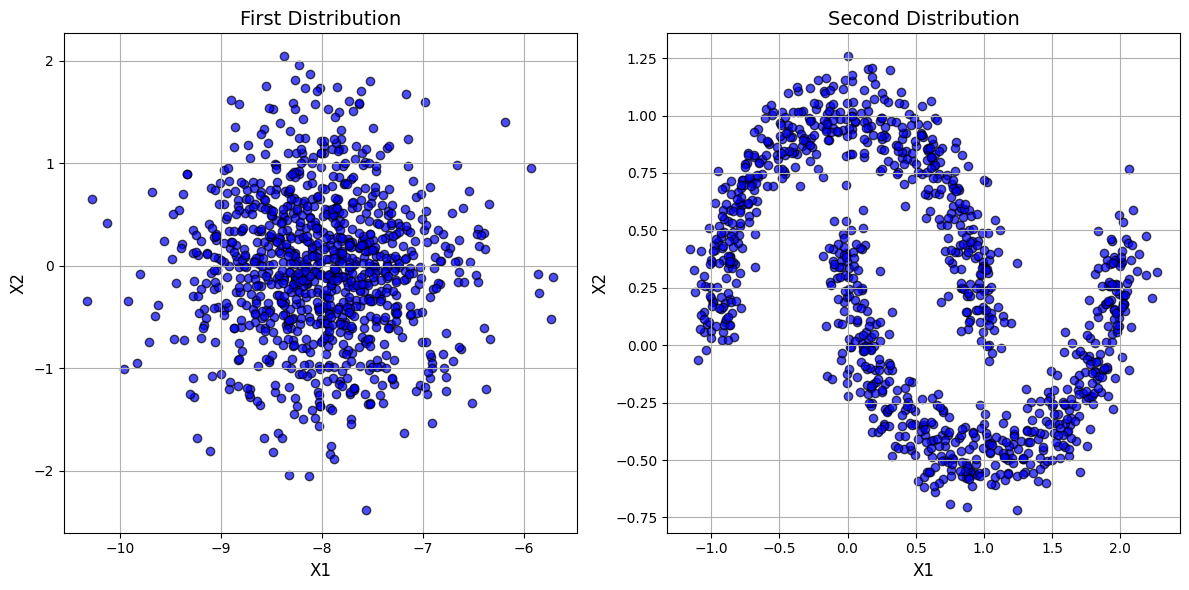

In [106]:
offset = np.array([-8, 0])

# mu=np.array([[0, 0], [3, 3]]) + offset
mu=np.array([[0, 0], [0, 0]]) + offset
Sigma=[np.diag([0.5, 0.5]), np.diag([0.5, 0.5])]

mu_2 = np.array([[2, 2], [1, 5]])
Sigma_2 = [np.diag([0.5, 0.5]), np.diag([0.5, 0.5])]

# plot the two distributions next to each other
X_0 = sample_GMM(mu=mu, Sigma=Sigma, alpha=np.array([0.5, 0.5]), n_samples=1000)
X_1 = generate_half_moons(1000)

# X_2 = sample_GMM(mu=mu_2, Sigma=Sigma_2, alpha=np.array([0.5, 0.5]), n_samples=1000)

plot_two_distrib(X_0, X_1)

In [87]:
# fit a GMM to the data
n_comp_1 = 10
n_comp_2 = 10
gmm_1 = GaussianMixture(n_components=n_comp_1)
gmm_2 = GaussianMixture(n_components=n_comp_2)

gmm_1.fit(X_0)
# print('First distribution :\n mean =', gmm_1.means_, '\n covariance =', gmm_1.covariances_)

gmm_2.fit(X_1)
# print('Second distribution :\n mean =', gmm_2.means_, '\n covariance =', gmm_2.covariances_)


GaussianMixture(n_components=10)

In [88]:
means0 = gmm_1.means_
covs0 = gmm_1.covariances_
weights0 = gmm_1.weights_   

means1 = gmm_2.means_
covs1 = gmm_2.covariances_
weights1 = gmm_2.weights_

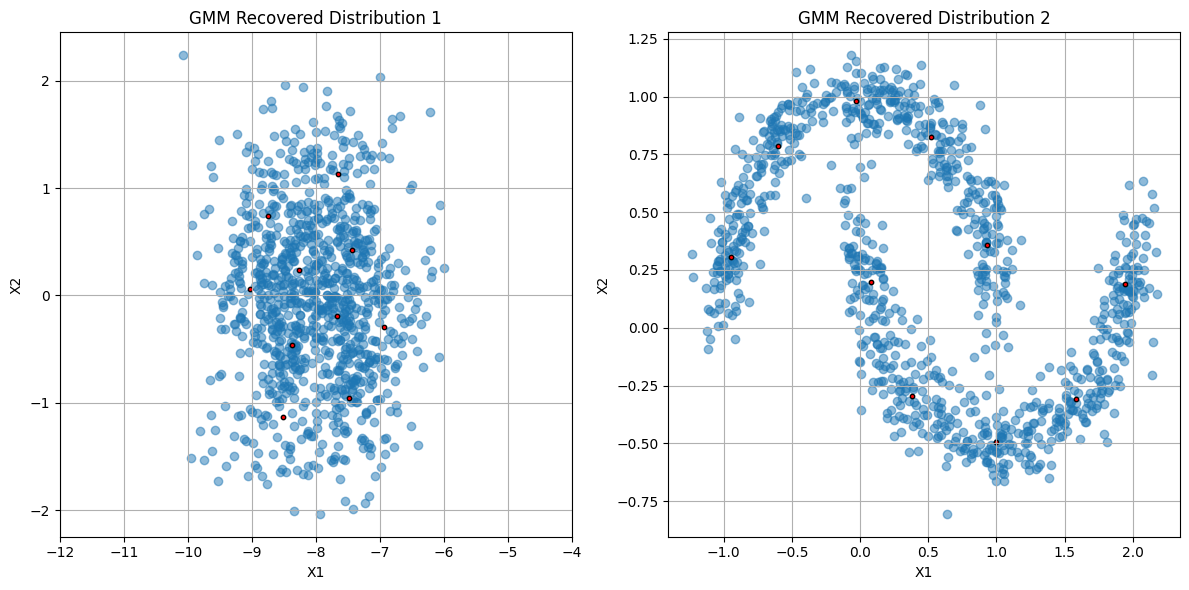

In [89]:
# Plot the two distributions using plot_gmm_2d
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plot_gmm_2d(means0, covs0, weights0, xlim=[-12, -4], ylim=None, ax=axs[0], n_samples=1000)
axs[0].set_title('GMM Recovered Distribution 1')

plot_gmm_2d(means1, covs1, weights1, xlim=None, ylim=None, ax=axs[1], n_samples=1000)
axs[1].set_title('GMM Recovered Distribution 2')

plt.tight_layout()
plt.show()

In [90]:
# Compute optimal transport plan w*
w_star, C = compute_optimal_coupling(means0, covs0, weights0, means1, covs1, weights1)

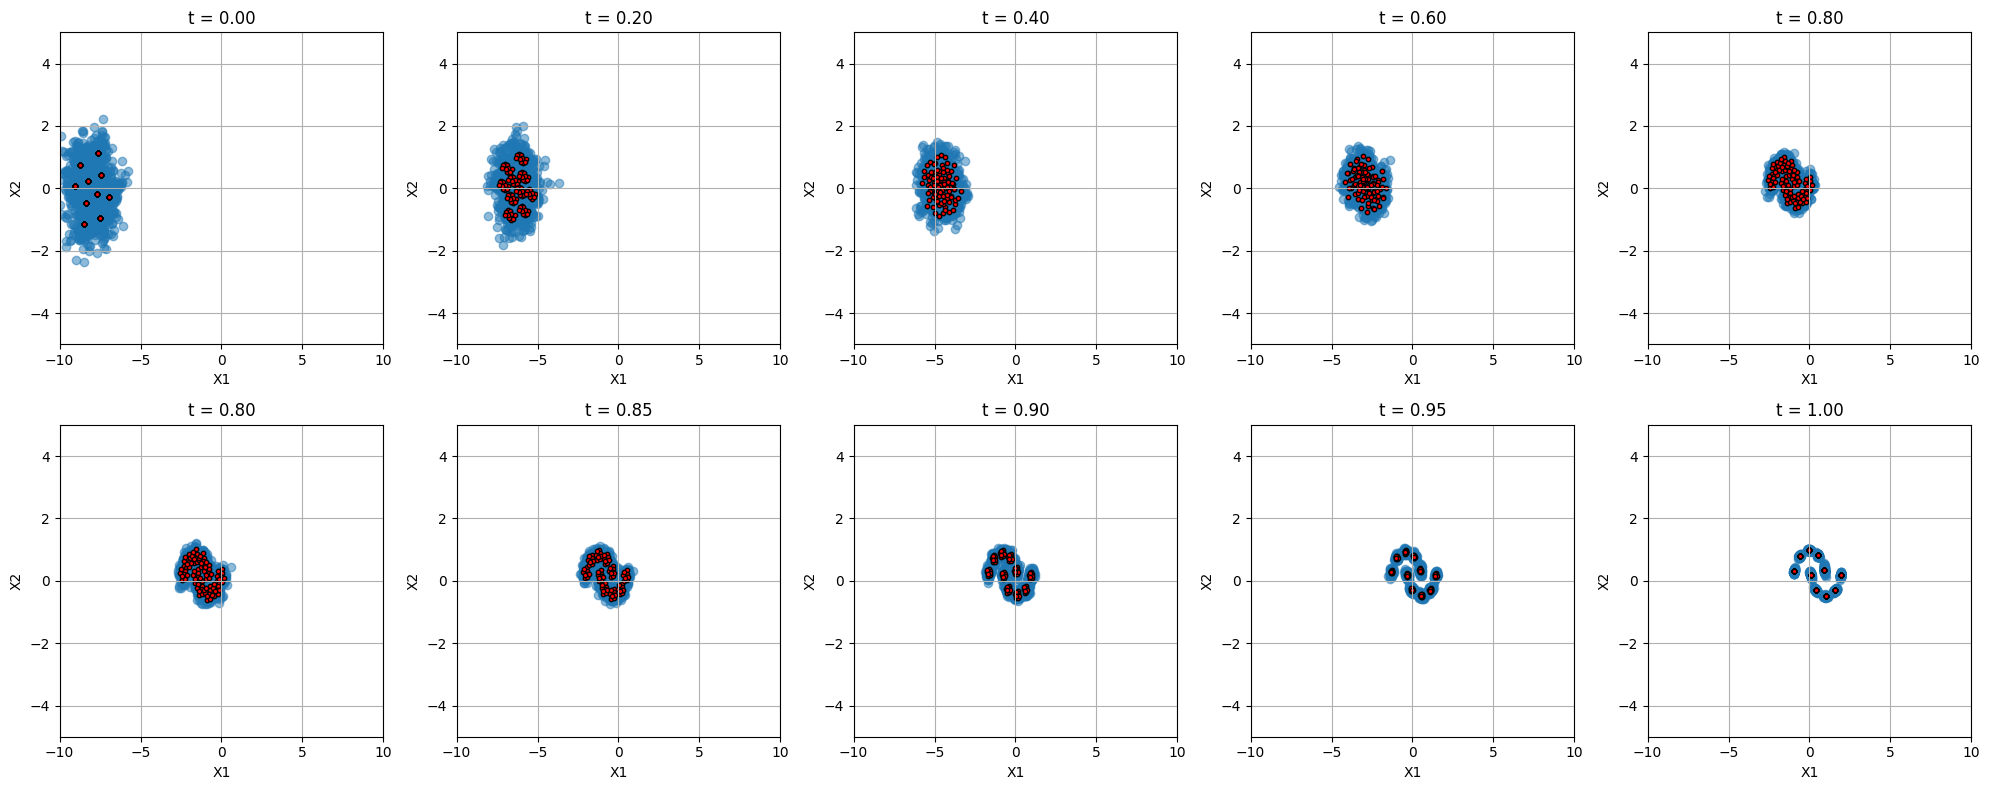

In [91]:
t = np.linspace(0, 0.8, 5)
t_prime = np.linspace(0.8, 1, 5)
t = np.concatenate((t, t_prime))
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axs.flatten()):
    interpolated_means, interpolated_covs, interpolated_weights = compute_interpolated_gmm(means0, covs0, weights0, means1, covs1, weights1, w_star, t[i])
    plot_gmm_2d(interpolated_means, interpolated_covs, interpolated_weights, xlim=[-10, 10], ylim=[-5, 5], ax=ax, n_samples=1000)
    ax.set_title(f't = {t[i]:.2f}')
plt.tight_layout()
plt.show()

In [94]:
# Apply transport map to the first distribution
X_transported_rand = transport_gmm_rand(means0, covs0, weights0, means1, covs1, weights1, w_star, X_0)
X_transported_mean = transport_gmm_mean(means0, covs0, weights0, means1, covs1, weights1, w_star, X_0)
X_transported_mode = transport_gmm_mode(means0, covs0, weights0, means1, covs1, weights1, w_star, X_0)

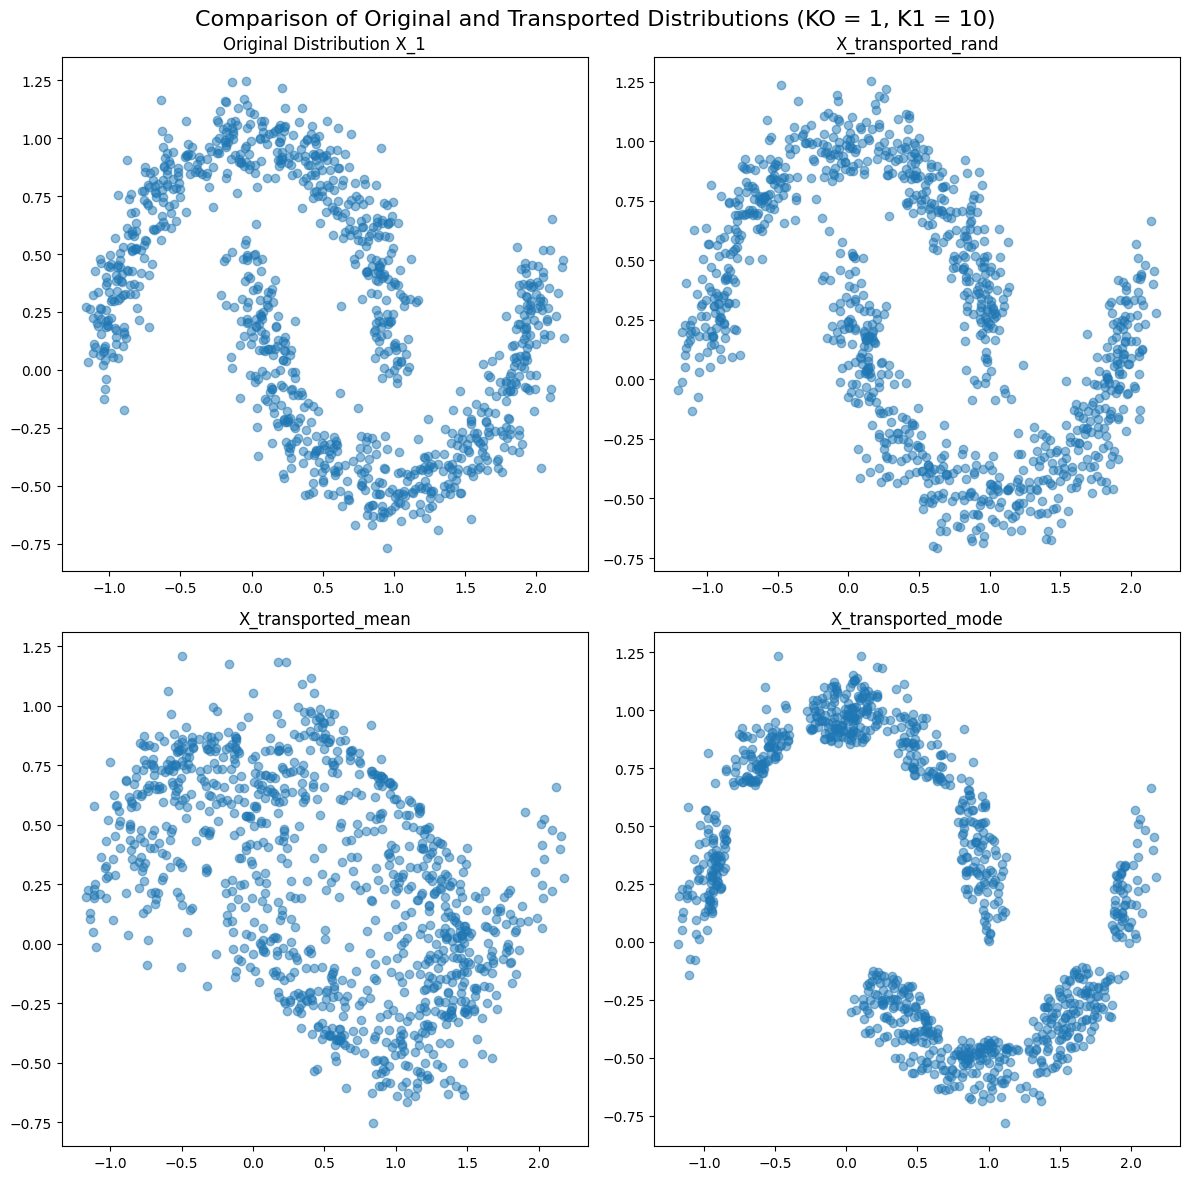

In [95]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot original distribution X_1
axs[0, 0].scatter(X_1[:, 0], X_1[:, 1], alpha=0.5, label='X_1')
axs[0, 0].set_title('Original Distribution X_1')

# X_transported_rand
axs[0, 1].scatter(X_transported_rand[:, 0], X_transported_rand[:, 1], alpha=0.5, label='X_transported_rand')
axs[0, 1].set_title('X_transported_rand')

# X_transported_mean
axs[1, 0].scatter(X_transported_mean[:, 0], X_transported_mean[:, 1], alpha=0.5, label='X_transported_mean')
axs[1, 0].set_title('X_transported_mean')

# X_transported_mode
axs[1, 1].scatter(X_transported_mode[:, 0], X_transported_mode[:, 1], alpha=0.5, label='X_transported_mode')
axs[1, 1].set_title('X_transported_mode')

fig.suptitle('Comparison of Original and Transported Distributions (KO = 1, K1 = 10)', fontsize=16)

plt.tight_layout()
plt.show()

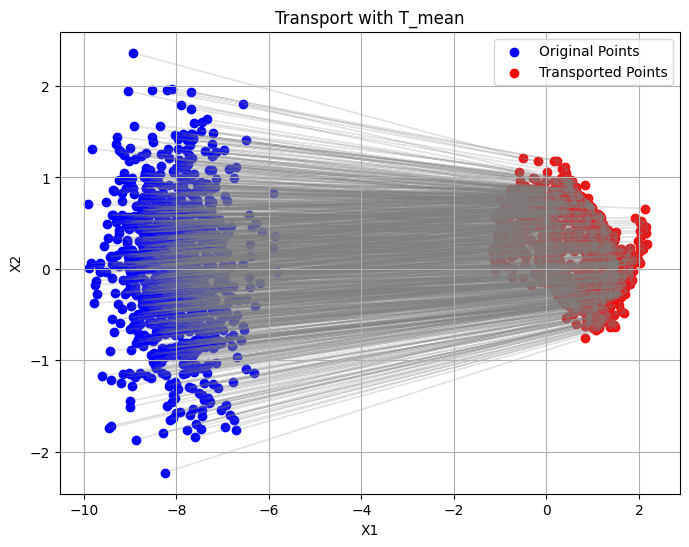

In [102]:
plot_transport(X_0, X_transported_mean, title='Transport with T_mean')

Costs: [74186.2767142  74283.10327218 74565.26530125]
Names: ['Mean', 'Mode', 'Random']


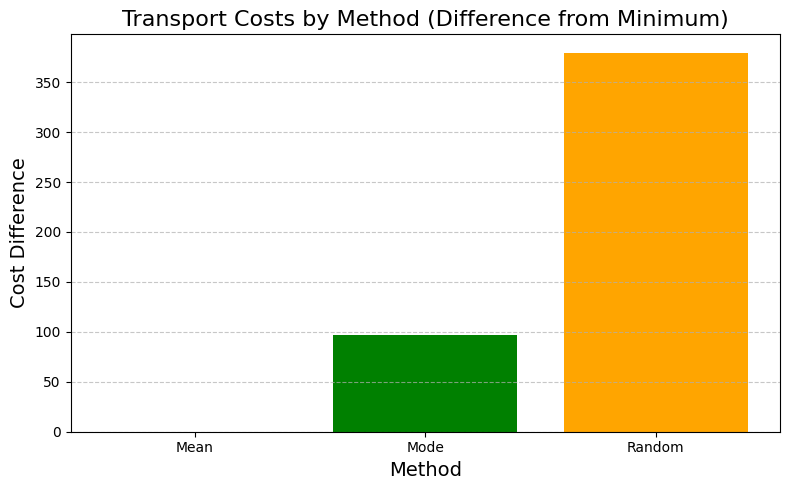

In [ ]:
rand_cost = compute_transport_cost(X_0, X_transported_rand)
mean_cost = compute_transport_cost(X_0, X_transported_mean)
mode_cost = compute_transport_cost(X_0, X_transported_mode)

# Sort and print the costs in the right order wih the right names
costs = np.array([rand_cost, mean_cost, mode_cost])
names = ['Random', 'Mean', 'Mode']
sorted_costs = np.sort(costs)
sorted_names = [name for _, name in sorted(zip(costs, names))]
print(f'Costs: {sorted_costs}')
print(f'Names: {sorted_names}')
# Create a bar plot for the transport costs with differences highlighted
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(sorted_names, sorted_costs - sorted_costs.min(), color=['blue', 'green', 'orange'])
ax.set_title('Transport Costs by Method (Difference from Minimum)', fontsize=16)
ax.set_ylabel('Cost Difference', fontsize=14)
ax.set_xlabel('Method', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Color transfer

Using the insights from the previous section, we can now apply the GMM optimal transport to color transfer. The idea is to transfer the color distribution of an image to another image.

In [146]:
# Image transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

im1 = Image.open("../images/SK-A-8.jpg")
im1 = transform(im1)
im1 = np.array(im1)

im2 = Image.open("../images/SK-A-29.jpg")
im2 = transform(im2)
im2 = np.array(im2)

im1 = im1[:, ::3, ::3,]
im2 = im2[:, ::3, ::3,]

im1_size_x, im1_size_y = im1.shape[1:]
im2_size_x, im2_size_y = im2.shape[1:]

im1 = im1.reshape(3, -1)
im2 = im2.reshape(3, -1)

/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_43247/3793286681.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  im1 = np.array(im1)
/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_43247/3793286681.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  im2 = np.array(im2)


In [147]:
X_1 = im1.T
X_2 = im2.T

In [149]:
# Apply transport map to the first distribution
X_transported_mean = fit_and_transport(X_1, X_2, n_comp_1=1, n_comp_2=10, method='mean')
X_transported_rand = fit_and_transport(X_1, X_2, n_comp_1=1, n_comp_2=10, method='rand')
X_transported_mode = fit_and_transport(X_1, X_2, n_comp_1=1, n_comp_2=10, method='mode')

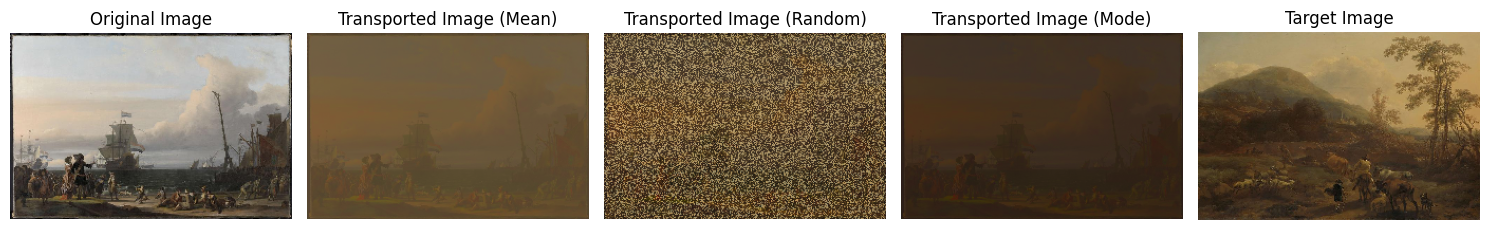

In [150]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# Original image
X_r = X_1.T.reshape(3, im1_size_x, im1_size_y).T
X_r = np.transpose(X_r, (1, 0, 2))
axes[0].imshow(X_r)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Transported image
X_transported_mean_r = X_transported_mean.T.reshape(3, im1_size_x, im1_size_y).T
X_transported_mean_r = np.transpose(X_transported_mean_r, (1, 0, 2))
axes[1].imshow(X_transported_mean_r)
axes[1].set_title('Transported Image (Mean)')
axes[1].axis('off')

X_transported_rand_r = X_transported_rand.T.reshape(3, im1_size_x, im1_size_y).T
X_transported_rand_r = np.transpose(X_transported_rand_r, (1, 0, 2))
axes[2].imshow(X_transported_rand_r)
axes[2].set_title('Transported Image (Random)')
axes[2].axis('off')

X_transported_mode_r = X_transported_mode.T.reshape(3, im1_size_x, im1_size_y).T
X_transported_mode_r = np.transpose(X_transported_mode_r, (1, 0, 2))
axes[3].imshow(X_transported_mode_r)
axes[3].set_title('Transported Image (Mode)')
axes[3].axis('off')

# Target image
im2_r = im2.reshape(3, im2_size_x, im2_size_y).T
im2_r = np.transpose(im2_r, (1, 0, 2))
axes[4].imshow(im2_r)
axes[4].set_title('Target Image')
axes[4].axis('off')

plt.tight_layout()
plt.show()

In [151]:
# Apply transport map to the first distribution
X_transported_mean = fit_and_transport(X_1, X_2, n_comp_1=10, n_comp_2=10, method='mean')
X_transported_rand = fit_and_transport(X_1, X_2, n_comp_1=10, n_comp_2=10, method='rand')
X_transported_mode = fit_and_transport(X_1, X_2, n_comp_1=10, n_comp_2=10, method='mode')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07017535499707561..0.8466020426771809].


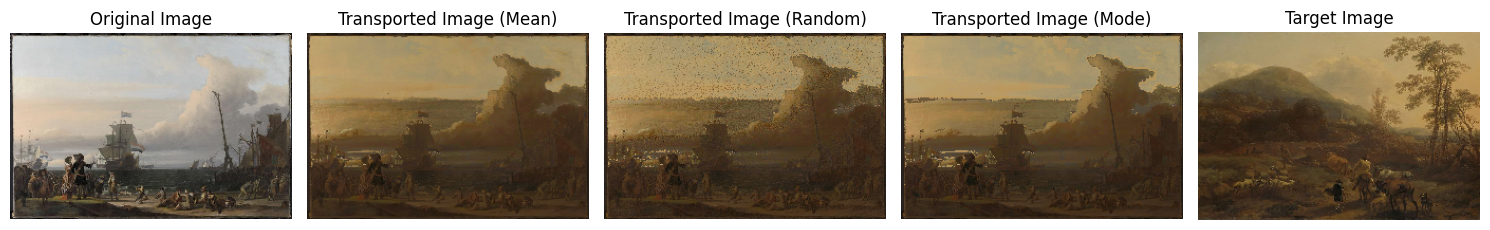

In [152]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# Original image
X_r = X_1.T.reshape(3, im1_size_x, im1_size_y).T
X_r = np.transpose(X_r, (1, 0, 2))
axes[0].imshow(X_r)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Transported image
X_transported_mean_r = X_transported_mean.T.reshape(3, im1_size_x, im1_size_y).T
X_transported_mean_r = np.transpose(X_transported_mean_r, (1, 0, 2))
axes[1].imshow(X_transported_mean_r)
axes[1].set_title('Transported Image (Mean)')
axes[1].axis('off')

X_transported_rand_r = X_transported_rand.T.reshape(3, im1_size_x, im1_size_y).T
X_transported_rand_r = np.transpose(X_transported_rand_r, (1, 0, 2))
axes[2].imshow(X_transported_rand_r)
axes[2].set_title('Transported Image (Random)')
axes[2].axis('off')

X_transported_mode_r = X_transported_mode.T.reshape(3, im1_size_x, im1_size_y).T
X_transported_mode_r = np.transpose(X_transported_mode_r, (1, 0, 2))
axes[3].imshow(X_transported_mode_r)
axes[3].set_title('Transported Image (Mode)')
axes[3].axis('off')

# Target image
im2_r = im2.reshape(3, im2_size_x, im2_size_y).T
im2_r = np.transpose(im2_r, (1, 0, 2))
axes[4].imshow(im2_r)
axes[4].set_title('Target Image')
axes[4].axis('off')

plt.tight_layout()
plt.show()

## Transporting 1 onto 6

### Using a compressed latent space

In [101]:
vae_mnist = torch.load("../models/vae_mnist.pt")
vae = VAE_MNIST()
vae.load_state_dict(vae_mnist)

<All keys matched successfully>

In [102]:
autoencoder_mnist = torch.load("../models/autoencoder_mnist.pth")
autoencoder = Autoencoder_MNIST()
autoencoder.load_state_dict(autoencoder_mnist)

<All keys matched successfully>

In [103]:
# the path is one folder up from the current directory
MNIST_path = '../'

batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(MNIST_path, train=True, transform=transform, download=False)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

In [104]:
# We get the embeddings of ones and sixes from the MNIST dataset

i = 0

for batch, labels in train_loader:
    ones = batch[labels==1]
    sixes = batch[labels==6]
    with torch.no_grad():
        if i==0:
            ones_latents_vae, _ = vae.encoder(ones)
            sixes_latents_vae, _ = vae.encoder(sixes)
            ones_latents_ae = autoencoder.encoder(ones)
            sixes_latents_ae = autoencoder.encoder(sixes)
        else:
            ones_latent_vae, _ = vae.encoder(ones)
            sixes_latent_vae, _ = vae.encoder(sixes)
            ones_latents_vae = np.concatenate((ones_latents_vae, ones_latent_vae), axis=0)
            sixes_latents_vae = np.concatenate((sixes_latents_vae, sixes_latent_vae), axis=0)
            ones_latent_ae = autoencoder.encoder(ones)
            sixes_latent_ae = autoencoder.encoder(sixes)
            ones_latents_ae = np.concatenate((ones_latents_ae, ones_latent_ae), axis=0)
            sixes_latents_ae = np.concatenate((sixes_latents_ae, sixes_latent_ae), axis=0)
    i+=1

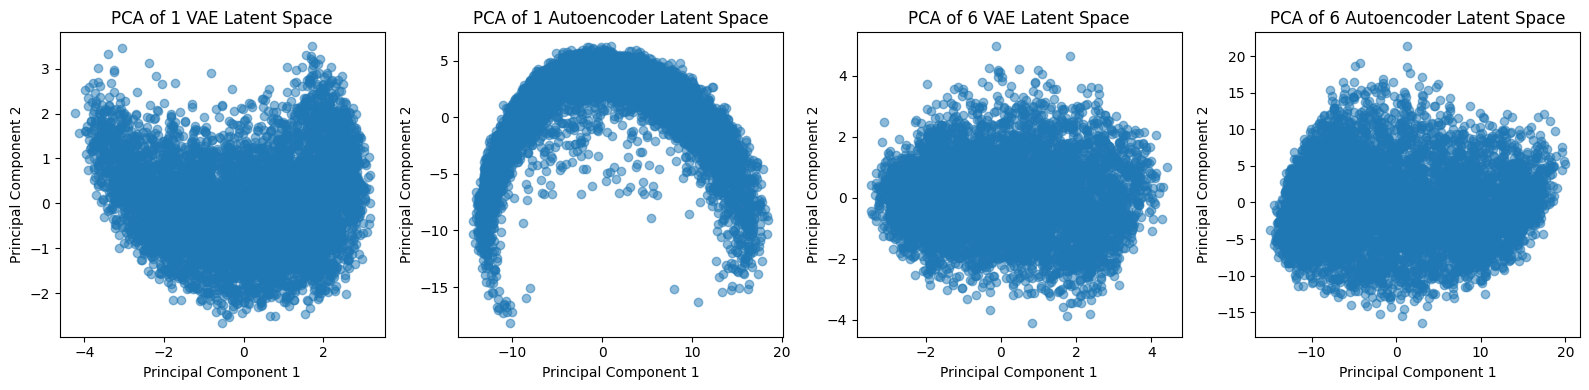

In [105]:
from sklearn.decomposition import PCA

# Perform PCA on the latent space of the VAE
pca_vae = PCA(n_components=2)
ones_latents_vae_pca = pca_vae.fit_transform(ones_latents_vae)
sixes_latents_vae_pca = pca_vae.fit_transform(sixes_latents_vae)

# Perform PCA on the latent space of the Autoencoder
pca_autoencoder = PCA(n_components=2)
ones_latents_ae_pca = pca_autoencoder.fit_transform(ones_latents_ae)
sixes_latents_ae_pca = pca_autoencoder.fit_transform(sixes_latents_ae)

# Plot the PCA results
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].scatter(ones_latents_vae_pca[:, 0], ones_latents_vae_pca[:, 1], alpha=0.5)
axes[0].set_title('PCA of 1 VAE Latent Space')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')

axes[1].scatter(ones_latents_ae_pca[:, 0], ones_latents_ae_pca[:, 1], alpha=0.5)
axes[1].set_title('PCA of 1 Autoencoder Latent Space')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')

axes[2].scatter(sixes_latents_vae_pca[:, 0], sixes_latents_vae_pca[:, 1], alpha=0.5)
axes[2].set_title('PCA of 6 VAE Latent Space')
axes[2].set_xlabel('Principal Component 1')
axes[2].set_ylabel('Principal Component 2')

axes[3].scatter(sixes_latents_ae_pca[:, 0], sixes_latents_ae_pca[:, 1], alpha=0.5)
axes[3].set_title('PCA of 6 Autoencoder Latent Space')
axes[3].set_xlabel('Principal Component 1')
axes[3].set_ylabel('Principal Component 2')

plt.tight_layout()
plt.show()


In [143]:
X_0 = ones_latents_ae
X_1 = sixes_latents_ae

In [144]:
# Apply transport map to the first distribution
X_transported_ae_mean = fit_and_transport(X_0, X_1, n_comp_1=10, n_comp_2=10, method='mean')
X_transported_ae_rand = fit_and_transport(X_0, X_1, n_comp_1=10, n_comp_2=10, method='rand')
X_transported_ae_mode = fit_and_transport(X_0, X_1, n_comp_1=10, n_comp_2=10, method='mode')

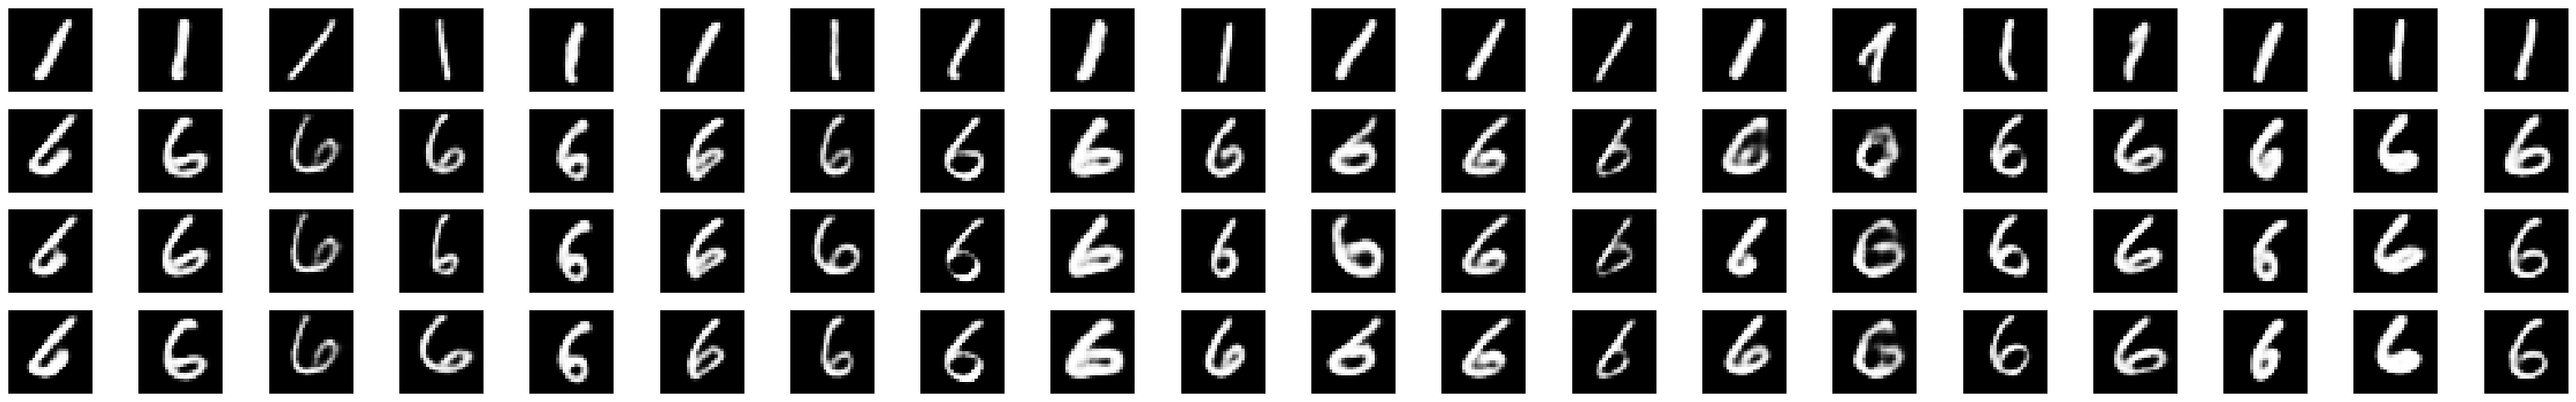

In [145]:
n_samples = 20

# Show samples from the WGAN and the VAE next to each other
with torch.no_grad():
    X_1_sample_tensor = torch.tensor(X_0[:n_samples], dtype=torch.float32)
    X_transported_ae_mean_sample_tensor = torch.tensor(X_transported_ae_mean[:n_samples], dtype=torch.float32)
    X_transported_ae_rand_sample_tensor = torch.tensor(X_transported_ae_rand[:n_samples], dtype=torch.float32)
    X_transported_ae_mode_sample_tensor = torch.tensor(X_transported_ae_mode[:n_samples], dtype=torch.float32)
    y_ae_1 = autoencoder.decoder(X_1_sample_tensor)
    y_ae_6_mean = autoencoder.decoder(X_transported_ae_mean_sample_tensor)
    y_ae_6_rand = autoencoder.decoder(X_transported_ae_rand_sample_tensor)
    y_ae_6_mode = autoencoder.decoder(X_transported_ae_mode_sample_tensor)

show_samples(y_ae_1, y_ae_6_mean, y_ae_6_rand, y_ae_6_mode, num_samples=n_samples, title="")

In [140]:
X_0 = ones_latents_vae
X_1 = sixes_latents_vae

In [141]:
# Apply transport map to the first distribution
X_transported_vae_mean = fit_and_transport(X_0, X_1, n_comp_1=10, n_comp_2=10, method='mean')
X_transported_vae_rand = fit_and_transport(X_0, X_1, n_comp_1=10, n_comp_2=10, method='rand')
X_transported_vae_mode = fit_and_transport(X_0, X_1, n_comp_1=10, n_comp_2=10, method='mode')

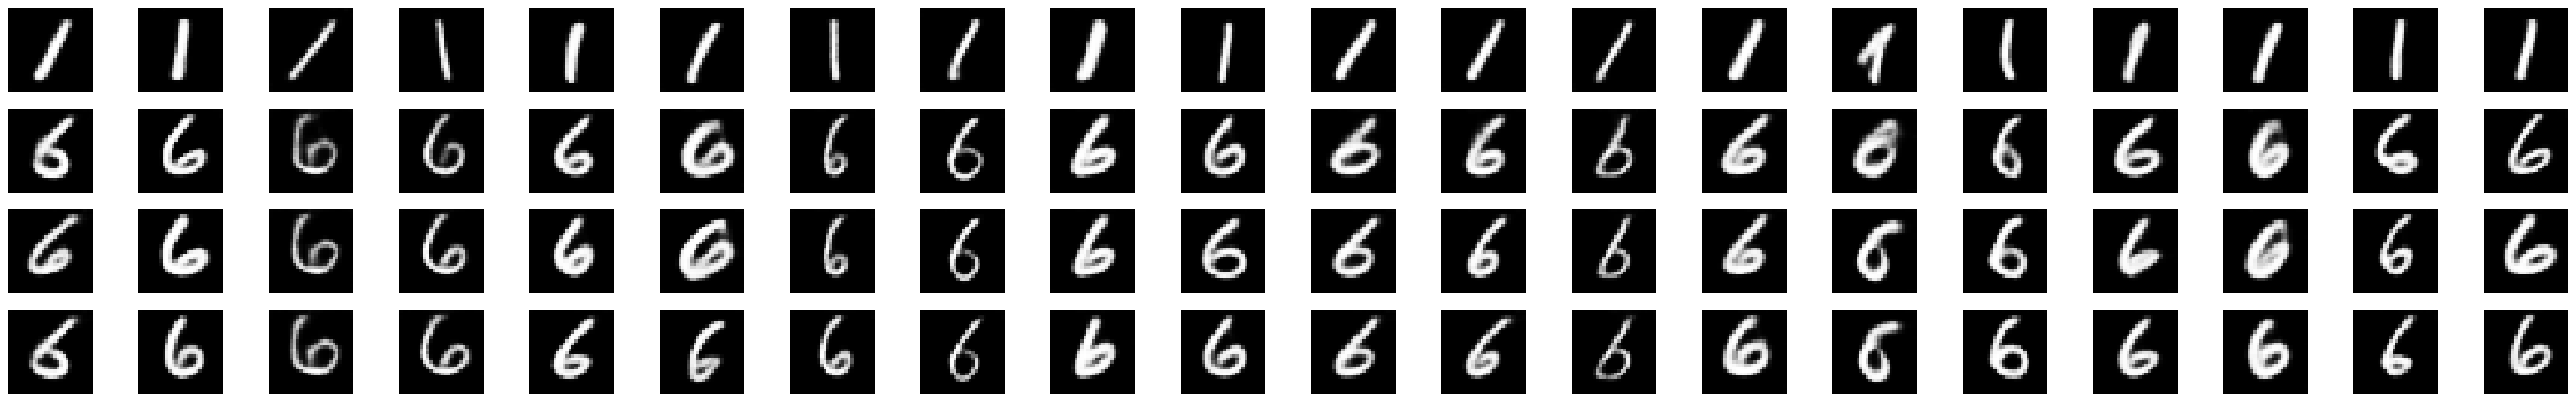

In [142]:
n_samples = 20

# Show samples from the WGAN and the VAE next to each other
with torch.no_grad():
    X_1_sample_tensor = torch.tensor(X_0[:n_samples], dtype=torch.float32)
    X_transported_vae_mean_sample_tensor = torch.tensor(X_transported_vae_mean[:n_samples], dtype=torch.float32)
    X_transported_vae_rand_sample_tensor = torch.tensor(X_transported_vae_rand[:n_samples], dtype=torch.float32)
    X_transported_vae_mode_sample_tensor = torch.tensor(X_transported_vae_mode[:n_samples], dtype=torch.float32)
    y_vae_1 = vae.decoder(X_1_sample_tensor)
    y_vae_6_mean = vae.decoder(X_transported_vae_mean_sample_tensor)
    y_vae_6_rand = vae.decoder(X_transported_vae_rand_sample_tensor)
    y_vae_6_mode = vae.decoder(X_transported_vae_mode_sample_tensor)

show_samples(y_vae_1, y_vae_6_mean, y_vae_6_rand, y_vae_6_mode, num_samples=n_samples, title="")

### Using the original data space

In [95]:
# We get the ones and sixes from the MNIST dataset

i = 0

for batch, labels in train_loader:
    if i==0:
        ones = batch[labels==1]
        sixes = batch[labels==6]
    else : 
        one = batch[labels==1]
        six = batch[labels==6]
        ones = np.concatenate((ones, one), axis=0)
        sixes = np.concatenate((sixes, six), axis=0)
    i+=1
    

In [96]:
X_0 = ones.reshape(-1, 28*28)
X_1 = sixes.reshape(-1, 28*28)

In [8]:
# fit a GMM to the data
n_comp_1 = 25
n_comp_2 = 25
gmm_1 = GaussianMixture(n_components=n_comp_1)
gmm_2 = GaussianMixture(n_components=n_comp_2)

gmm_1.fit(X_0)
# print('First distribution :\n mean =', gmm_1.means_, '\n covariance =', gmm_1.covariances_)

gmm_2.fit(X_1)
# print('Second distribution :\n mean =', gmm_2.means_, '\n covariance =', gmm_2.covariances_)

GaussianMixture(n_components=25)

In [139]:
# Save gmm_1 and gmm_2 to files
with open('gmm_MNIST_1_25.pkl', 'wb') as f:
    pickle.dump(gmm_1, f)

with open('gmm_MNIST_6_25.pkl', 'wb') as f:
    pickle.dump(gmm_2, f)

print("GMMs saved successfully.")

GMMs saved successfully.


In [ ]:
# Load GMMs from files
with open('gmm_MNIST_1_25.pkl', 'rb') as f:
    gmm_1 = pickle.load(f)

with open('gmm_MNIST_6_25.pkl', 'rb') as f:
    gmm_2 = pickle.load(f)

print("GMMs loaded successfully.")

GMMs loaded successfully.


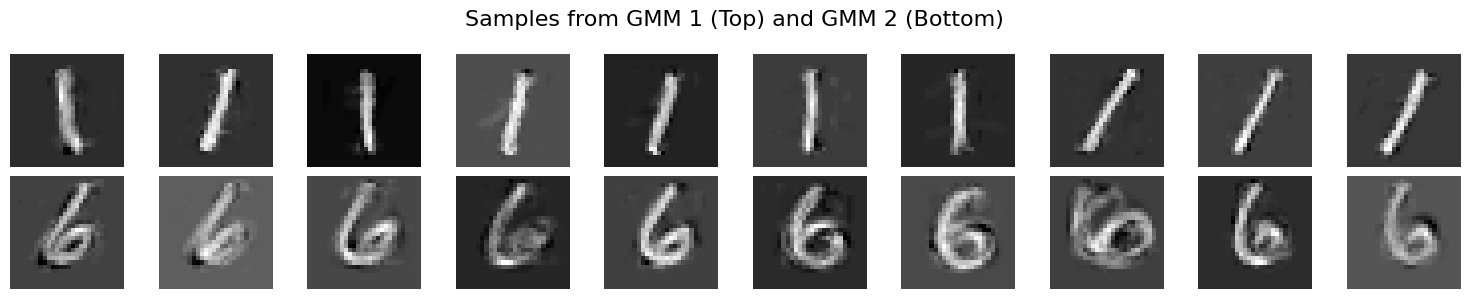

In [24]:
# Generate samples from gmm_1 and gmm_2
n_samples = 10
samples_gmm_1, _ = gmm_1.sample(n_samples)
samples_gmm_2, _ = gmm_2.sample(n_samples)

# Reshape the samples to 28x28 images
samples_gmm_1_images = samples_gmm_1.reshape(-1, 28, 28)
samples_gmm_2_images = samples_gmm_2.reshape(-1, 28, 28)


# Plot the samples as images
fig, ax = plt.subplots(2, n_samples, figsize=(15, 3))

for i in range(n_samples):
    ax[0, i].imshow(samples_gmm_1_images[i], cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(samples_gmm_2_images[i], cmap='gray')
    ax[1, i].axis('off')

plt.suptitle('Samples from GMM 1 (Top) and GMM 2 (Bottom)', fontsize=16)
plt.tight_layout()
plt.show()

In [10]:
means0 = gmm_1.means_
covs0 = gmm_1.covariances_
weights0 = gmm_1.weights_   

means1 = gmm_2.means_
covs1 = gmm_2.covariances_
weights1 = gmm_2.weights_

# Compute optimal transport weights w*
# w_star, C = compute_optimal_coupling(means0, covs0, weights0, means1, covs1, weights1)

In [11]:
# Save w_star and C to a file
with open('w_star_MNIST_25_25.pkl', 'wb') as f:
    pickle.dump(w_star, f)

with open('C_MNIST_25_25.pkl', 'wb') as f:
    pickle.dump(C, f)

print("w_star and C saved successfully.")

w_star and C saved successfully.


In [8]:
# Load w_star and C from files
with open('w_star_MNIST_50_50.pkl', 'rb') as f:
    w_star = pickle.load(f)

with open('C_MNIST_50_50.pkl', 'rb') as f:
    C = pickle.load(f)

print("w_star and C loaded successfully.")

w_star and C loaded successfully.


In [15]:
# Apply transport map to the first distribution
X_transported = transport_gmm_rand_optimized(means0, covs0, weights0, means1, covs1, weights1, w_star, X_0)

/Users/samsongourevitch/Documents/MVA_Gen_Mod/GMM_OT/GMM_OT/gmmot.py:305: ComplexWarning: Casting complex values to real discards the imaginary part
  X_transported[i] = compute_transport_gaussian(means0[k], covs0[k], means1[l], covs1[l], X[i:i+1])


In [29]:
X_0_r = X_0.reshape(-1, 28, 28)
X_transported_r = X_transported.reshape(-1, 28, 28)

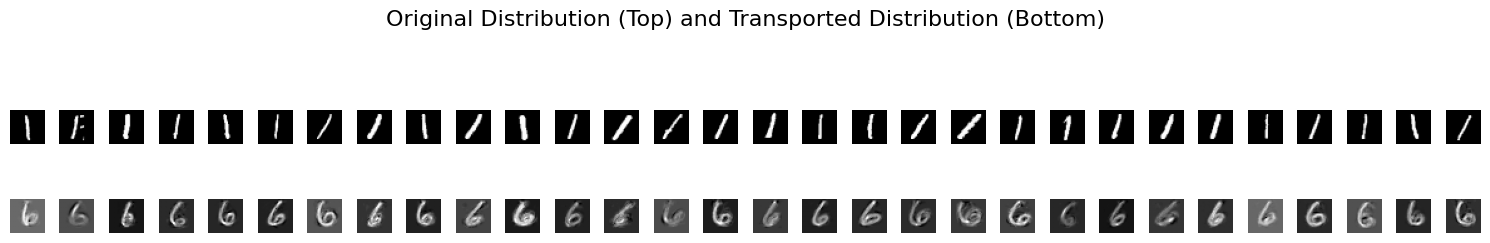

In [32]:
# plot the first 10 images of the original and transported distributions

n_samples = 30

fig, ax = plt.subplots(2, n_samples, figsize=(15, 3))

for i in range(n_samples):
    ax[0, i].imshow(X_0_r[i], cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(X_transported_r[i], cmap='gray')
    ax[1, i].axis('off')

plt.suptitle('Original Distribution (Top) and Transported Distribution (Bottom)', fontsize=16)
plt.tight_layout()
plt.show()